In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import torch

from tokenizer.fr_en_tokenizer import Tokenizer
from data.dataset import TranslationDataset, get_dataloader

from configs.transformer_512dh8_e6d6 import model_params, train_params, valid_params

In [10]:
# device
device = torch.device(
    "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
)

# tokenizer
warped_tokenizer = Tokenizer(model_params['seq_len'])

# src special tokens
print(warped_tokenizer.src_tokenizer.bos_token_id)
print(warped_tokenizer.src_tokenizer.eos_token_id)
print(warped_tokenizer.src_tokenizer.pad_token_id)
print(warped_tokenizer.src_tokenizer.unk_token_id)
# tgt special tokens
print(warped_tokenizer.tgt_tokenizer.bos_token_id)
print(warped_tokenizer.tgt_tokenizer.eos_token_id)
print(warped_tokenizer.tgt_tokenizer.pad_token_id)
print(warped_tokenizer.tgt_tokenizer.unk_token_id)

59514
0
59513
1
59514
0
59513
1


In [4]:
# 加载数据
train_loader = get_dataloader("train", batch_size=train_params['batch_size'], warped_tokenizer=warped_tokenizer)
val_loader = get_dataloader("validation", batch_size=valid_params['batch_size'], warped_tokenizer=warped_tokenizer)

Loading train dataset into memory from cache
Loaded 232825 samples
Loading validation dataset into memory from cache
Loaded 890 samples


In [5]:
# 检查数据
for batch in train_loader:
    src, tgt = batch
    print(src.shape, tgt.shape)
    break

torch.Size([48, 121]) torch.Size([48, 107])


In [6]:
test_loader = get_dataloader("test", batch_size=valid_params['batch_size'], warped_tokenizer=warped_tokenizer)

Tokenizing test dataset into memory: 100%|██████████| 8597/8597 [00:03<00:00, 2309.36it/s]


Tokenized 8597 samples
Saved test dataset into cachee...


In [8]:
for batch in test_loader:
    src_text, tgt_text, src, tgt = batch
    print(src.shape, tgt.shape)
    print(len(src_text), len(tgt_text))
    print(src_text[0], tgt_text[0])
    print(src[0], tgt[0])
    break

torch.Size([48, 73]) torch.Size([48, 67])
48 48
Il y a plusieurs années, ici à Ted, Peter Skillman a présenté une épreuve de conception appelée l'épreuve du marshmallow. Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge.
tensor([  104,   167,    15,   652,   655,     2,   769,    17, 32860,     2,
         4593, 17072,  5360,   883,    15,  1873,    38, 17651,     5,  3125,
        10088,    14,     6, 16980,    22,  1093,   400,  6184,  7642,     3,
        59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513]) tensor([59514,  7981,   302,  2544,   479,    71,   267,  2735,     2,  4593,
        45643,   883,  3378,    15,  1527,  4086,  1381,     4, 

In [11]:
from utils.helper import MaskMaker
mask_maker = MaskMaker(warped_tokenizer=warped_tokenizer)

In [14]:
for batch in train_loader:
    src, tgt = batch
    print(src.shape, tgt.shape)
    masks = mask_maker.create_masks(src, tgt)
    print("src_mask: ", masks['tgt_mask'].shape, masks['tgt_mask'])
    print("tgt_mask: ", masks['tgt_mask'].shape, masks['tgt_mask'])
    print("src_padding_mask: ", masks['src_key_padding_mask'].shape, masks['src_key_padding_mask'][0])
    print("tgt_padding_mask: ", masks['tgt_key_padding_mask'].shape, masks['tgt_key_padding_mask'][0])
    break

torch.Size([48, 121]) torch.Size([48, 107])
src_mask:  torch.Size([107, 107]) tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tgt_mask:  torch.Size([107, 107]) tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])
src_padding_mask:  torch.Size([48, 121]) tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  T

In [8]:
def lr_lambda(iteration): # scheduler used in Attention is All You Need
    warmup_steps = 4000
    step_num = iteration + 1
    arg1 = step_num ** -0.5
    arg2 = step_num * (warmup_steps ** -1.5)
    lr = (512 ** -0.5) * min(arg1, arg2)
    return lr
        
print(lr_lambda(4000))

0.000698683912937353


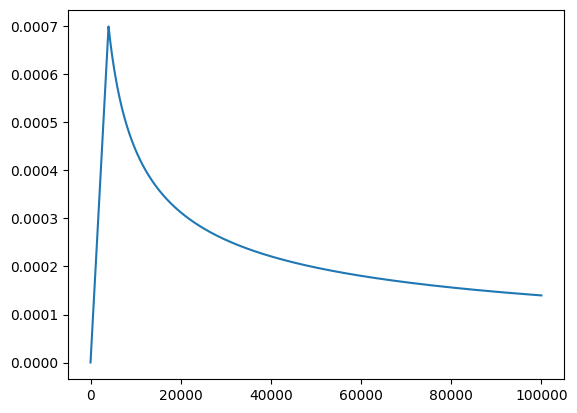

In [9]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 100000)
y = [lr_lambda(i) for i in x]
plt.plot(x, y)
plt.show()

In [12]:
import torch

def lr_lambda_2(epoch):
    warmup_epoch = 6
    down = 8
    if epoch < warmup_epoch:
        return (epoch+1) / (warmup_epoch+1)
    elif epoch < down:
        return 1
    else: 
        return torch.exp(torch.tensor(-0.2 * (epoch - down))) # 0.1 for more epochs

print(lr_lambda_2(9))

tensor(0.8187)


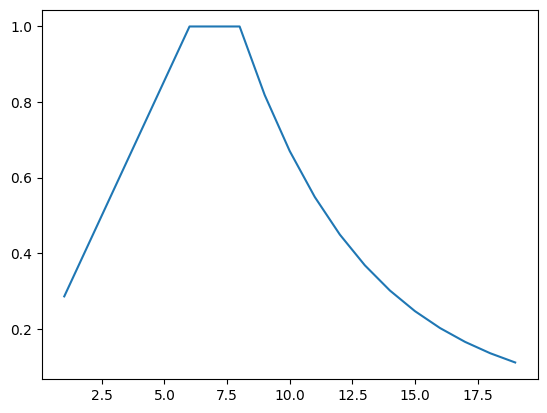

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 20)
y = [lr_lambda_2(i) for i in x]
plt.plot(x, y)
plt.show()